In [1]:
import sys
import os
import time
import numpy as np
import pinocchio as pin
import importlib
import tqdm
sys.path.append('../python/bsqp')
np.set_printoptions(linewidth=99999999)
np.random.seed(42)

class GATO:
    def __init__(self, N, dt, batch_size, f_ext_std, max_sqp_iters=8, kkt_tol=0.005, max_pcg_iters=50, pcg_tol=1e-3):
        module_name = f"bsqpN{N}" 
        try: lib = importlib.import_module(module_name)
        except ImportError as e: raise ValueError(f"Number of knots {N} not supported (could not import {module_name}): {e}")
        
        class_name = f"BSQP_{batch_size}_float" 
        if not hasattr(lib, class_name): raise ValueError(f"Batch size {batch_size} not supported in module {module_name}")
        
        self.solver = getattr(lib, class_name)(dt, max_sqp_iters, kkt_tol, max_pcg_iters, pcg_tol, 1.0, 1.0, 0, 0, 0, 0, 0)
        
        self.N = N
        self.dt = dt
        self.batch_size = batch_size
        if f_ext_std == 0.0:
            self.f_ext_batch = np.zeros((self.batch_size, 6))
        else:
            self.f_ext_batch = np.random.normal(0, f_ext_std, (self.batch_size, 6))
            self.f_ext_batch[:, 3:] = 0.0
            self.f_ext_batch[0] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  
        self.solver.set_f_ext_batch(self.f_ext_batch)
        
        self.stats = {
            'solve_time': {'values': [], 'unit': 'us', 'multiplier': 1},
            'pcg_iters': {'values': [], 'unit': '', 'multiplier': 1},
            "step_size": {"values": [], "unit": "", "multiplier": 1},
            'sqp_iters': {'values': [], 'unit': '', 'multiplier': 1}
        }
        
    def solve(self, x_curr_batch, eepos_goals_batch, XU_batch):
        result = self.solver.solve(XU_batch, self.dt, x_curr_batch, eepos_goals_batch)
        self.stats['solve_time']['values'].append(result["sqp_time_us"])
        self.stats['sqp_iters']['values'].append(result["sqp_iters"])
        self.stats['pcg_iters']['values'].append(result["pcg_iters"])
        self.stats["step_size"]["values"].append(result["ls_step_size"])
        return result["XU"], result["sqp_time_us"]
    
    def sim_forward(self, xk, uk, sim_dt):
        x_next_batch = self.solver.sim_forward(xk, uk, sim_dt)
        return x_next_batch # [batch size x nx]
    
    # [batch size x 6]
    def set_f_ext_batch(self, f_ext_batch):
        self.solver.set_f_ext_batch(f_ext_batch)
        
    def reset_dual(self):
        self.solver.reset_dual()
        
    def get_stats(self):
        return self.stats
    

class MPC_GATO:
    def __init__(self, model, N=32, dt=0.1, batch_size=1, constant_f_ext=None, f_ext_std=0.0, f_ext_resample_std=0.0):
        self.points = np.load('points1000.npy')[1:]
        
        self.model = model
        self.model.gravity.linear = np.array([0, 0, -9.81])
        self.data = model.createData()
        
        self.solver = GATO(N, dt, batch_size, f_ext_std=f_ext_std)
        self.q_traj = []  # trajectory for visualization
        
        self.nq = self.model.nq
        self.nv = self.model.nv
        self.nx = self.nq + self.nv
        self.nu = len(self.model.joints) - 1
        
        self.q_home = self.eepos(np.zeros(self.nq))
        
        if f_ext_resample_std != 0:
            self.resample_f_ext = True
            self.f_ext_resample_std = f_ext_resample_std
        else:
            self.resample_f_ext = False
            self.f_ext_resample_std = 0.0
        
        if constant_f_ext is not None:
            forces = pin.StdVec_Force()
            for _ in range(self.model.njoints-1):
                forces.append(pin.Force.Zero())
            f_ext = pin.Force(constant_f_ext[:3], np.array([0, 0, 0]))
            forces.append(f_ext)
            self.actual_f_ext = forces
        else:
            self.constant_f_ext = pin.StdVec_Force()
            for _ in range(self.model.njoints):
                self.constant_f_ext.append(pin.Force.Zero())
                
    def run_mpc_point(self, x_start, ee_goal_point, sim_dt=0.001, sim_time=5):        
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'ee_goal': []
        }
        total_time = 0.0
        
        
        x_curr, q, dq = x_start, x_start[:self.nq], x_start[self.nq:self.nx]
        x_curr_batch = np.tile(x_curr, (self.solver.batch_size, 1))
        ee_g = np.tile(np.concatenate([ee_goal_point, np.zeros(3)]), (self.solver.N, 1))
        ee_g_batch = np.tile(ee_g, (self.solver.batch_size, 1))
        XU = np.zeros(self.solver.N*(self.nx+self.nu)-self.nu)
        for i in range(self.solver.N):
            start_idx = i * (self.nx + self.nu)
            XU[start_idx:start_idx+self.nx] = x_curr
        self.solver.reset_dual()
        XU_batch = np.tile(XU, self.solver.batch_size)
        for _ in range(10): # warm up runs
            XU_batch, solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch) 
        XU_best = XU_batch[0, :]
        
        # print(f"\n========== Running MPC for {sim_time} seconds ==========\n")
        
        for i in range(20):
            print(f'Point {i}: {self.points[i]}, {self.points[i+1]}')
            
            total_sim_time = 0.0
            steps = 0
            accumulated_time = 0.0
            
            q, dq = np.zeros(self.nq), np.zeros(self.nq)
            self.solver.reset_dual()
            ee_g = np.tile(np.concatenate([self.points[i], np.zeros(3)]), (self.solver.N, 1))
            ee_g_batch = np.tile(ee_g, (self.solver.batch_size, 1))
            while total_sim_time < sim_time:
                if np.linalg.norm(self.eepos(q)[:3] - ee_g[0, :3]) < 0.2 and np.linalg.norm(dq, ord=1) < 1.0:
                    print(f"Goal 1 reached in {total_sim_time} seconds")
                    break
                
                # simulate forward
                timestep = solve_time/1e6
                #sim_time_step = max(self.solver.dt, solve_time) #sim_dt  # hard coded timestep for now, realistically should be trajopt solver time
                
                x_last = x_curr
                u_last = XU_best[self.nx:self.nx+self.nu]
                
                nsteps = int(timestep/sim_dt)
                for i in range(nsteps):
                    offset = int(i/(self.solver.dt/sim_dt)) # get correct control input
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                if timestep%sim_dt > 1e-4:
                    accumulated_time += timestep%sim_dt
                    
                if accumulated_time - sim_dt > 0.0:
                    accumulated_time = 0.0
                    
                    offset = int(nsteps/(self.solver.dt/sim_dt))
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                x_curr = np.concatenate([q, dq])
                
                # ----- Optimize trajectory -----
                #self.solver.reset_lambda()
                
                x_curr_batch = np.tile(x_curr, self.solver.batch_size)
                XU_batch[:, :self.nx] = x_curr
                XU_batch_new, solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
                best_id = self.find_best_idx(np.array(x_last), np.array(u_last), np.array(x_curr), sim_dt) # find best traj after sim step (match dynamics)
                XU_best = XU_batch_new[best_id, :]
                XU_batch[:, :] = XU_best
                # -----
                
                stats['solve_times'].append(float(round(solve_time/1e3, 5)))
                goaldist = np.sqrt(np.sum((self.eepos(q)[:3] - ee_g[0, :3])**2))
                stats['ee_goal'].append(ee_g[6:9])
                stats['goal_distances'].append(float(round(goaldist, 5)))
                steps += 1
                if steps % 5000 == 0:
                    f_ext_str = " ".join([f"{force:4.3f}" for force in self.solver.f_ext_batch[best_id]])
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | t_sqp=\033[92m{solve_time/1e3:4.3f}\033[0m ms | id={best_id} | fext=[{f_ext_str}] | t={total_sim_time:4.3f}s")

            self.solver.reset_dual()    
            ee_g = np.tile(np.concatenate([self.q_home, np.zeros(3)]), (self.solver.N, 1))
            ee_g_batch = np.tile(ee_g, (self.solver.batch_size, 1))
            while total_sim_time < sim_time:
                if np.linalg.norm(self.eepos(q)[:3] - ee_g[0, :3]) < 0.3:
                    print(f"Home reached in {total_sim_time} seconds")
                    break
                
                # simulate forward
                timestep = solve_time/1e6
                #sim_time_step = max(self.solver.dt, solve_time) #sim_dt  # hard coded timestep for now, realistically should be trajopt solver time
                
                x_last = x_curr
                u_last = XU_best[self.nx:self.nx+self.nu]
                
                nsteps = int(timestep/sim_dt)
                for i in range(nsteps):
                    offset = int(i/(self.solver.dt/sim_dt)) # get correct control input
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                if timestep%sim_dt > 1e-4:
                    accumulated_time += timestep%sim_dt
                    
                if accumulated_time - sim_dt > 0.0:
                    accumulated_time = 0.0
                    
                    offset = int(nsteps/(self.solver.dt/sim_dt))
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                x_curr = np.concatenate([q, dq])
                
                # ----- Optimize trajectory -----
                #self.solver.reset_lambda()
                
                x_curr_batch = np.tile(x_curr, self.solver.batch_size)
                XU_batch[:, :self.nx] = x_curr
                XU_batch_new, solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
                best_id = self.find_best_idx(np.array(x_last), np.array(u_last), np.array(x_curr), sim_dt) # find best traj after sim step (match dynamics)
                XU_best = XU_batch_new[best_id, :]
                XU_batch[:, :] = XU_best
                # -----
                
                stats['solve_times'].append(float(round(solve_time/1e3, 5)))
                goaldist = np.sqrt(np.sum((self.eepos(q)[:3] - ee_g[0, :3])**2))
                stats['ee_goal'].append(ee_g[6:9])
                stats['goal_distances'].append(float(round(goaldist, 5)))
                steps += 1
                if steps % 5000 == 0:
                    f_ext_str = " ".join([f"{force:4.3f}" for force in self.solver.f_ext_batch[best_id]])
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | t_sqp=\033[92m{solve_time/1e3:4.3f}\033[0m ms | id={best_id} | fext=[{f_ext_str}] | t={total_sim_time:4.3f}s")

            self.solver.reset_dual()    
            ee_g = np.tile(np.concatenate([self.points[i+1], np.zeros(3)]), (self.solver.N, 1))
            ee_g_batch = np.tile(ee_g, (self.solver.batch_size, 1))
            while total_sim_time < sim_time:
                if np.linalg.norm(self.eepos(q)[:3] - ee_g[0, :3]) < 0.2 and np.linalg.norm(dq, ord=1) < 1.0:
                    print(f"Goal 2 reached in {total_sim_time} seconds")
                    break
                
                # simulate forward
                timestep = solve_time/1e6
                #sim_time_step = max(self.solver.dt, solve_time) #sim_dt  # hard coded timestep for now, realistically should be trajopt solver time
                
                x_last = x_curr
                u_last = XU_best[self.nx:self.nx+self.nu]
                
                nsteps = int(timestep/sim_dt)
                for i in range(nsteps):
                    offset = int(i/(self.solver.dt/sim_dt)) # get correct control input
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                if timestep%sim_dt > 1e-4:
                    accumulated_time += timestep%sim_dt
                    
                if accumulated_time - sim_dt > 0.0:
                    accumulated_time = 0.0
                    
                    offset = int(nsteps/(self.solver.dt/sim_dt))
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                x_curr = np.concatenate([q, dq])
                
                # ----- Optimize trajectory -----
                #self.solver.reset_lambda()
                
                x_curr_batch = np.tile(x_curr, self.solver.batch_size)
                XU_batch[:, :self.nx] = x_curr
                XU_batch_new, solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
                best_id = self.find_best_idx(np.array(x_last), np.array(u_last), np.array(x_curr), sim_dt) # find best traj after sim step (match dynamics)
                XU_best = XU_batch_new[best_id, :]
                XU_batch[:, :] = XU_best
                # -----
                
                stats['solve_times'].append(float(round(solve_time/1e3, 5)))
                goaldist = np.sqrt(np.sum((self.eepos(q)[:3] - ee_g[0, :3])**2))
                stats['ee_goal'].append(ee_g[6:9])
                stats['goal_distances'].append(float(round(goaldist, 5)))
                steps += 1
                if steps % 5000 == 0:
                    f_ext_str = " ".join([f"{force:4.3f}" for force in self.solver.f_ext_batch[best_id]])
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | t_sqp=\033[92m{solve_time/1e3:4.3f}\033[0m ms | id={best_id} | fext=[{f_ext_str}] | t={total_sim_time:4.3f}s")

            self.solver.reset_dual()   
            ee_g = np.tile(np.concatenate([self.q_home, np.zeros(3)]), (self.solver.N, 1))
            ee_g_batch = np.tile(ee_g, (self.solver.batch_size, 1))
            while total_sim_time < sim_time:
                if np.linalg.norm(self.eepos(q)[:3] - ee_g[0, :3]) < 0.3:
                    print(f"Home reached in {total_sim_time} seconds")
                    break
                
                # simulate forward
                timestep = solve_time/1e6
                #sim_time_step = max(self.solver.dt, solve_time) #sim_dt  # hard coded timestep for now, realistically should be trajopt solver time
                
                x_last = x_curr
                u_last = XU_best[self.nx:self.nx+self.nu]
                
                nsteps = int(timestep/sim_dt)
                for i in range(nsteps):
                    offset = int(i/(self.solver.dt/sim_dt)) # get correct control input
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                if timestep%sim_dt > 1e-4:
                    accumulated_time += timestep%sim_dt
                    
                if accumulated_time - sim_dt > 0.0:
                    accumulated_time = 0.0
                    
                    offset = int(nsteps/(self.solver.dt/sim_dt))
                    u = XU_best[self.nx+(self.nx+self.nu)*offset:(self.nx+self.nu)*(offset+1)]
                    q, dq = self.rk4(q, dq, u, sim_dt)
                    total_sim_time += sim_dt
                    self.q_traj.append(q)
                    
                x_curr = np.concatenate([q, dq])
                
                # ----- Optimize trajectory -----
                #self.solver.reset_lambda()
                
                x_curr_batch = np.tile(x_curr, self.solver.batch_size)
                XU_batch[:, :self.nx] = x_curr
                XU_batch_new, solve_time = self.solver.solve(x_curr_batch, ee_g_batch, XU_batch)
                best_id = self.find_best_idx(np.array(x_last), np.array(u_last), np.array(x_curr), sim_dt) # find best traj after sim step (match dynamics)
                XU_best = XU_batch_new[best_id, :]
                XU_batch[:, :] = XU_best
                # -----
                
                stats['solve_times'].append(float(round(solve_time/1e3, 5)))
                goaldist = np.sqrt(np.sum((self.eepos(q)[:3] - ee_g[0, :3])**2))
                stats['ee_goal'].append(ee_g[6:9])
                stats['goal_distances'].append(float(round(goaldist, 5)))
                steps += 1
                if steps % 5000 == 0:
                    f_ext_str = " ".join([f"{force:4.3f}" for force in self.solver.f_ext_batch[best_id]])
                    print(f"err=\033[91m{goaldist:4.3f}\033[0m | t_sqp=\033[92m{solve_time/1e3:4.3f}\033[0m ms | id={best_id} | fext=[{f_ext_str}] | t={total_sim_time:4.3f}s")

            total_time += total_sim_time
            print(f"\n\n{(total_sim_time < sim_time)}\n\n")
        
        # print(f"avg err: {np.mean(stats['goal_distances']):4.3f}")
        print(f"\navg t_sqp: {np.mean(stats['solve_times']):4.3f}ms")
        print(f"total time: {total_time:4.3f}s")

        return self.q_traj, stats
    
    def get_ee_g_traj(self, traj, offset):
        if offset >= len(traj)/6 - 6*self.solver.N:
            print("=> end of trajectory, wrapping around")
            offset %= len(traj)/6
        return traj[6*offset:6*(offset+self.solver.N)]
    
    def rk4(self, q, dq, u, dt):
        k1q = dq
        k1v = pin.aba(self.model, self.data, q, dq, u, self.actual_f_ext)
        q2 = pin.integrate(self.model, q, k1q * dt / 2)
        k2q = dq + k1v * dt/2
        k2v = pin.aba(self.model, self.data, q2, k2q, u, self.actual_f_ext)
        q3 = pin.integrate(self.model, q, k2q * dt / 2)
        k3q = dq + k2v * dt/2
        k3v = pin.aba(self.model, self.data, q3, k3q, u, self.actual_f_ext)
        q4 = pin.integrate(self.model, q, k3q * dt)
        k4q = dq + k3v * dt
        k4v = pin.aba(self.model, self.data, q4, k4q, u, self.actual_f_ext)
        dq_next = dq + (dt/6) * (k1v + 2*k2v + 2*k3v + k4v)
        avg_dq = (k1q + 2*k2q + 2*k3q + k4q) / 6
        q_next = pin.integrate(self.model, q, avg_dq * dt)
        return q_next, dq_next
    
    def find_best_idx(self, x_last, u_last, x_curr, dt):
        if self.solver.batch_size == 1:
            return 0
        
        best_error, best_id = np.inf, 0
        
        x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
        for i in range(self.solver.batch_size):
            error = np.linalg.norm(x_next_batch[i, :] - x_curr)
            if error <= best_error:
                best_error = error
                best_id = i
                
        if self.resample_f_ext:
            f_ext_best = self.solver.f_ext_batch[best_id, :]
            self.solver.f_ext_batch = np.tile(f_ext_best, (self.solver.batch_size, 1))
            self.solver.f_ext_batch += np.random.normal(0, self.f_ext_resample_std, self.solver.f_ext_batch.shape)
            self.solver.f_ext_batch[1,:] = f_ext_best
            self.solver.f_ext_batch[0,:] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            self.solver.solver.set_f_ext_batch(self.solver.f_ext_batch)
                
        return best_id
            
    def eepos(self, q):
        pin.forwardKinematics(self.model, self.data, q)
        return self.data.oMi[6].translation


In [2]:
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
model_dir = os.path.join(parent_dir, "examples/indy7-mpc/description/")
urdf_path = os.path.join(model_dir, "indy7.urdf")

model, visual_model, collision_model = pin.buildModelsFromUrdf(urdf_path, model_dir)

N = 16
dt = 0.01
f_ext = np.array([40.0, 0.0, -40.0, 0.0, 0.0, 0.0])

mpc = MPC_GATO(model, N=N, dt=dt, constant_f_ext=f_ext)
mpc_batch = MPC_GATO(model, N=N, dt=dt, batch_size=32, constant_f_ext=f_ext, f_ext_std=1.0, f_ext_resample_std=0.1)

xstart = np.hstack((np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), np.zeros(mpc.nv)))

Device name: NVIDIA GeForce RTX 4090
Memory clock rate: 10501000 kHz
Bus width: 384 bits
Peak memory bandwidth: 1008.1 GB/s
Total global memory: 24210 MB
Shared memory per block: 48 kB
Concurrent kernels: 1
Total L2 cache size: 73728 kB
Setting persisting L2 size to: 50688 / 50688 kB
T : f
Device name: NVIDIA GeForce RTX 4090
Memory clock rate: 10501000 kHz
Bus width: 384 bits
Peak memory bandwidth: 1008.1 GB/s
Total global memory: 24210 MB
Shared memory per block: 48 kB
Concurrent kernels: 1
Total L2 cache size: 73728 kB
Setting persisting L2 size to: 50688 / 50688 kB
T : f


In [3]:
q_trajectory, mpc_stats = mpc.run_mpc_point(xstart, mpc.points[0], sim_dt=0.002, sim_time=7.0)
q_trajectory_batch, mpc_stats_batch = mpc_batch.run_mpc_point(xstart, mpc_batch.points[0], sim_dt=0.002, sim_time=7.0)

Point 0: [0.53067282 0.32937091 0.74113915], [0.18639171 0.90146974 0.17780675]
Goal 1 reached in 3.4979999999998364 seconds
Home reached in 3.4979999999998364 seconds
Goal 2 reached in 4.01199999999978 seconds
Home reached in 4.01199999999978 seconds


True


Point 1: [0.18639171 0.90146974 0.17780675], [-0.14142955 -0.17643389  0.42365216]
Goal 1 reached in 1.9780000000000015 seconds
Home reached in 1.9780000000000015 seconds
err=0.162 | t_sqp=0.559 ms | id=0 | fext=[0.000 0.000 0.000 0.000 0.000 0.000] | t=3.150s
Goal 2 reached in 4.815999999999692 seconds
Home reached in 4.815999999999692 seconds


True


Point 2: [-0.14142955 -0.17643389  0.42365216], [0.76672875 0.36807165 0.02421702]
Goal 1 reached in 1.0900000000000007 seconds
Home reached in 1.0900000000000007 seconds
err=0.568 | t_sqp=0.114 ms | id=0 | fext=[0.000 0.000 0.000 0.000 0.000 0.000] | t=3.904s
err=0.571 | t_sqp=1.090 ms | id=0 | fext=[0.000 0.000 0.000 0.000 0.000 0.000] | t=4.960s
err=0.572 | t_sqp=0.114 ms | id=

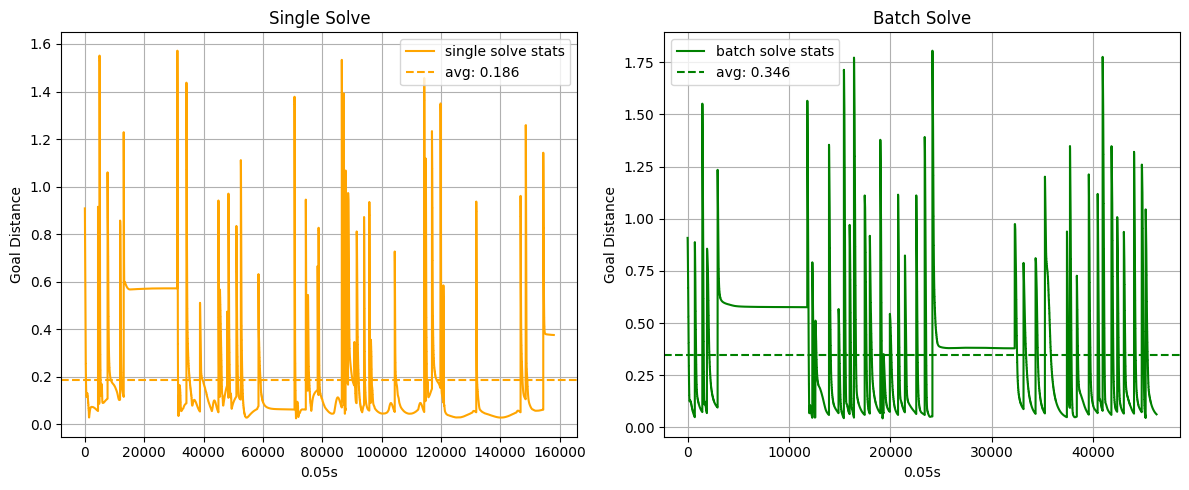

In [4]:
import matplotlib.pyplot as plt

# plot position error of mpc_stats_sample vs mpc_stats side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot - single solve stats
ax1.plot(mpc_stats['goal_distances'], label='single solve stats', color='orange')
single_avg = np.mean(mpc_stats['goal_distances'])
ax1.axhline(y=single_avg, color='orange', linestyle='--', label=f'avg: {single_avg:.3f}')
ax1.set_xlabel('0.05s')
ax1.set_ylabel('Goal Distance')
ax1.legend()
ax1.grid(True)
ax1.set_title('Single Solve')

# Second plot - batch solve stats  
ax2.plot(mpc_stats_batch['goal_distances'], label='batch solve stats', color='g')
batch_avg = np.mean(mpc_stats_batch['goal_distances'])
ax2.axhline(y=batch_avg, color='g', linestyle='--', label=f'avg: {batch_avg:.3f}')
ax2.set_xlabel('0.05s')
ax2.set_ylabel('Goal Distance')
ax2.legend()
ax2.grid(True)
ax2.set_title('Batch Solve')

plt.tight_layout()
plt.show()

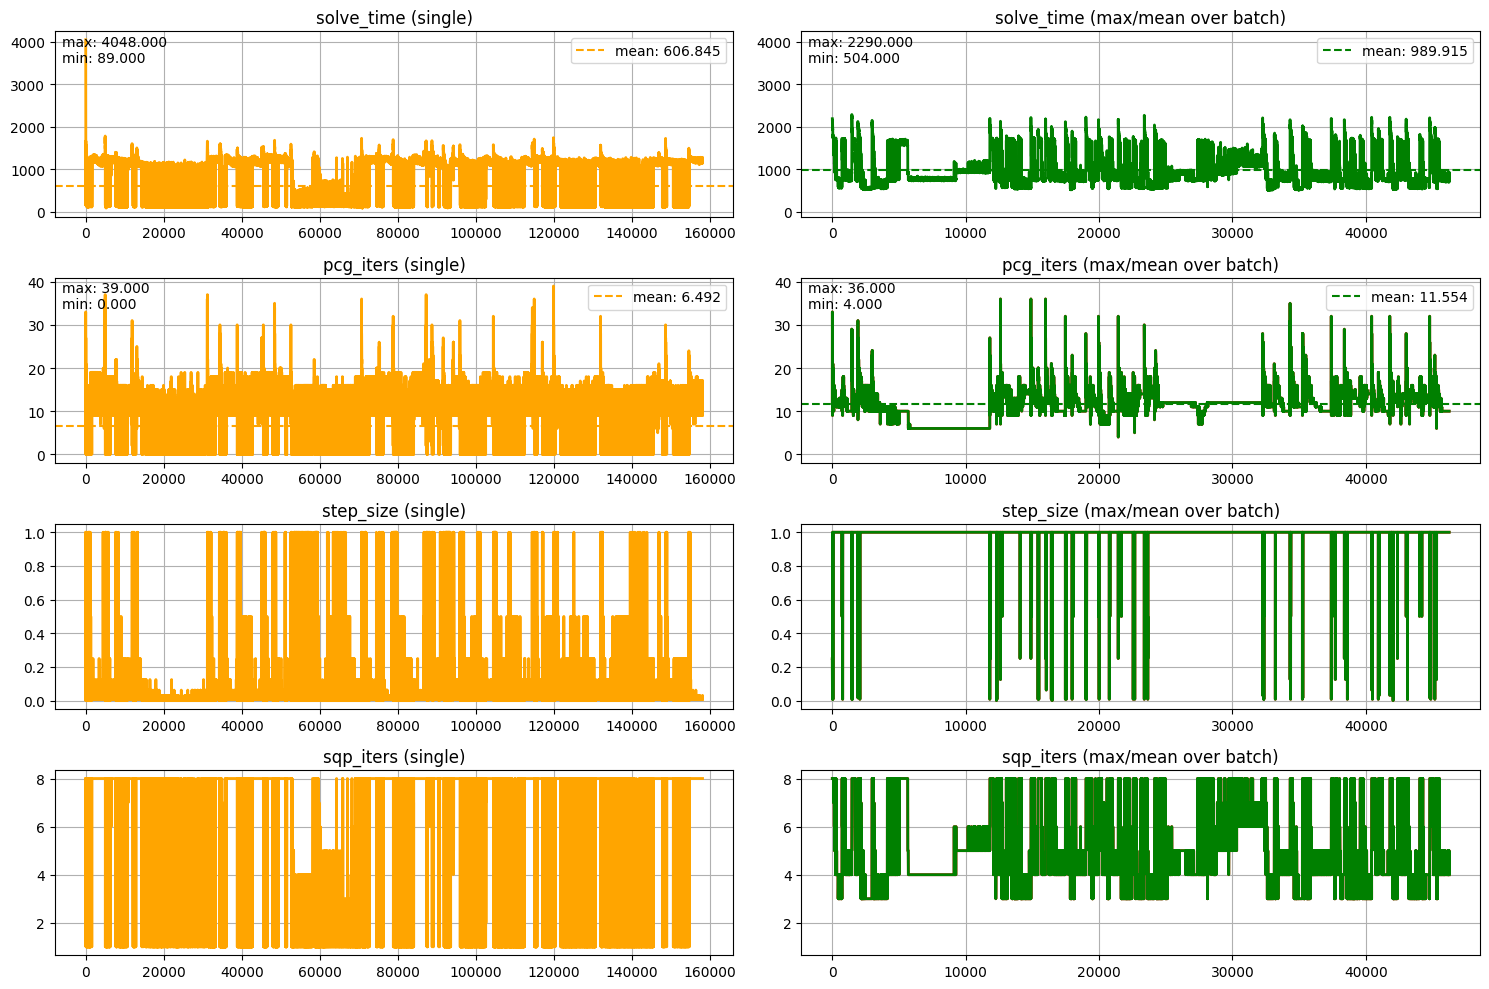

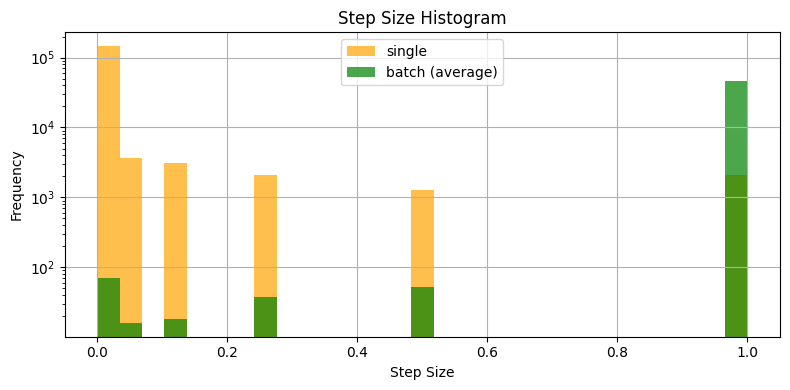

In [5]:
stats = mpc.solver.get_stats()
batch_stats = mpc_batch.solver.get_stats()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(stats), 2, figsize=(15, 2.5*len(stats)))
if len(stats) == 1:
    axs = [axs]

step_size_values = None
batch_step_size_values = None

for i, (key, data) in enumerate(stats.items()):
    ax = axs[i][0]  # Use first column
    ax2 = axs[i][1]  # Use second column
    if isinstance(data, dict) and 'values' in data:
        values = np.array(data['values'])
        batch_values = np.array(batch_stats[key]['values'])
        values = np.maximum(values, 0.0)  # Replace negative values with 0.0
        batch_values = np.maximum(batch_values, 0.0)
            
        if key == 'sqp_iters' or key == 'pcg_iters':
            max_batch = np.max(batch_values, axis=1)
            batch_values = np.mean(batch_values, axis=1)
            ax2.plot(range(len(max_batch)), max_batch, label='', linewidth=2.0, color='r')
            
        if key == 'step_size':
            ax2.plot(range(len(np.max(batch_values, axis=1))), np.max(batch_values, axis=1), label='', linewidth=2.0, color='r')
            batch_values = np.mean(batch_values, axis=1)
            step_size_values = values
            batch_step_size_values = batch_values
            
        ax2.plot(range(len(batch_values)), batch_values, label='', linewidth=2.0, color='g')
        ax.plot(range(len(values)), values, label='', linewidth=2.0, color='orange')
        ax.set_title(f'{key} (single)')
        ax2.set_title(f'{key} (max/mean over batch)')
            
        y_min = min(np.min(values), np.min(batch_values))
        y_max = max(np.max(values), np.max(batch_values))
        y_range = y_max - y_min
        y_min -= 0.05 * y_range  # Add 5% padding
        y_max += 0.05 * y_range
        ax.set_ylim(y_min, y_max)
        ax2.set_ylim(y_min, y_max)
        
        
        if key == 'solve_time' or key == 'pcg_iters':
            ax.axhline(np.mean(values), color='orange', linestyle='--', label=f'mean: {np.mean(values):.3f}')
            ax2.axhline(np.mean(batch_values), color='g', linestyle='--', label=f'mean: {np.mean(batch_values):.3f}')
            ax.text(0.01, 0.98, f'max: {np.max(values):.3f}\nmin: {np.min(values):.3f}', 
                   transform=ax.transAxes, verticalalignment='top')
            ax2.text(0.01, 0.98, f'max: {np.max(batch_values):.3f}\nmin: {np.min(batch_values):.3f}',
                    transform=ax2.transAxes, verticalalignment='top')        
    ax.grid(True)
    ax2.grid(True)
    
    if i <= 1:  # Only show legend for first subplot
        ax.legend()
        ax2.legend()
        
plt.tight_layout()
plt.show()

# Plot histogram of step sizes (single solve only)
if step_size_values is not None:
    plt.figure(figsize=(8, 4))
    bins = np.linspace(np.min(step_size_values), np.max(step_size_values), 30)
    plt.hist(step_size_values, bins=bins, alpha=0.7, 
             label='single', color='orange')
    plt.hist(batch_step_size_values, bins=bins, alpha=0.7, 
             label='batch (average)', color='g')
    
    plt.yscale('log')  # Use logarithmic scale for y-axis

    plt.xlabel('Step Size')
    plt.ylabel('Frequency')
    plt.title('Step Size Histogram')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [6]:
import meshcat.geometry as g
import meshcat.transformations as tf
from pinocchio.visualize import MeshcatVisualizer
import numpy as np

# load two robot models
model1, visual_model1, collision_model1 = pin.buildModelsFromUrdf(urdf_path, model_dir)
model2, visual_model2, collision_model2 = pin.buildModelsFromUrdf(urdf_path, model_dir)

# single visualizer
viz = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot1", color=[1.0, 0.0, 0.0, 0.4])
viz_2 = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz_2.initViewer(viz.viewer)
viz_2.loadViewerModel(rootNodeName="robot2", color=[0.0, 1.0, 0.0, 0.7])


# Create arrow to visualize force
f_ext = np.array([40.0, -10.0, -40.0])
force_magnitude = np.linalg.norm(f_ext[:3])
force_direction = f_ext[:3] / force_magnitude
arrow_length = force_magnitude / 100.0  # Scale down the force for visualization

# Create arrow geometry
arrow = g.Cylinder(height=arrow_length, radius=0.005)
arrow_2 = g.Cylinder(height=arrow_length, radius=0.005)
viz.viewer['force_arrow'].set_object(arrow, g.MeshLambertMaterial(color=0xffff00))
viz_2.viewer['force_arrow_2'].set_object(arrow_2, g.MeshLambertMaterial(color=0xffff00))
    
q_trajectory1, q_trajectory2 = q_trajectory, q_trajectory_batch

t = 0
if not q_trajectory1 or not q_trajectory2:
    raise ValueError("Trajectories not loaded correctly")

ratio = len(q_trajectory1) / len(q_trajectory2)
data1 = model1.createData()
data2 = model2.createData()
while True:
    # Calculate indices safely
    idx1 = int(t * ratio) % len(q_trajectory1)
    idx2 = t % len(q_trajectory2)

    # Display robot configurations
    viz.display(q_trajectory1[idx1])
    viz_2.display(q_trajectory2[idx2])

    # --- Update force arrow position and orientation ---
    pin.forwardKinematics(model1, data1, q_trajectory1[idx1])
    pin.updateFramePlacements(model1, data1)
    ee_position = data1.oMi[6].translation
    
    pin.forwardKinematics(model2, data2, q_trajectory2[idx2])
    pin.updateFramePlacements(model2, data2)
    ee_position_2 = data2.oMi[6].translation

    # --- Calculate Rotation ---
    default_axis = np.array([0., 1., 0.]) # Meshcat cylinder's axis
    dot_product = np.dot(default_axis, force_direction)
    dot_product = np.clip(dot_product, -1.0, 1.0)

    rot_angle = np.arccos(dot_product)
    rot_axis = np.cross(default_axis, force_direction)
    rot_axis /= np.linalg.norm(rot_axis) # Normalize rotation axis
    R = tf.rotation_matrix(rot_angle, rot_axis)

    T = tf.translation_matrix(ee_position - (arrow_length/2) * force_direction)
    T_2 = tf.translation_matrix(ee_position_2 - (arrow_length/2) * force_direction)
    viz.viewer['force_arrow'].set_transform(T @ R)
    viz_2.viewer['force_arrow_2'].set_transform(T_2 @ R)
    
    t += 1
    time.sleep(0.001) # display rate

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


/home/alex/a2r/gato/GATO/.venv/lib/python3.10/site-packages/cmeel.prefix/lib/python3.10/site-packages/pinocchio/visualize/meshcat_visualizer.py:913: DeprecatedWarning: The 'color' argument is deprecated and will be removed in a future version of Pinocchio. Consider using 'collision_color' and 'visual_color' instead.
  warnings.warn(


KeyboardInterrupt: 

In [9]:
# get q at point number 300 from q_trajectory_batch
q_at_300 = q_trajectory_batch[300]
print(q_at_300)


[-1.096711   -0.09903229  0.83125766 -0.10907673  0.49704404  0.01499449]
